In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
conti_stocks_df = pd.read_csv(r"D:\streamlit_learn\streamlit_learn\conti.csv")
conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-04 00:00:00+02:00,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-07 00:00:00+02:00,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-08 00:00:00+02:00,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-09 00:00:00+02:00,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-10 00:00:00+02:00,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


In [3]:
# Convert with timezone awareness
conti_stocks_df['Date'] = pd.to_datetime(conti_stocks_df['Date'], utc=True)

# Remove timestamp:
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.tz_localize(None)

# Now you can floor to day
conti_stocks_df['Date'] = conti_stocks_df['Date'].dt.floor('D')

conti_stocks_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-09-03,130.363816,130.431868,125.940084,126.994972,584498,0.0,0.0
1,2015-09-06,128.560311,128.798516,126.892907,128.185989,217077,0.0,0.0
2,2015-09-07,128.934631,132.779875,128.866579,131.078445,568550,0.0,0.0
3,2015-09-08,135.093821,135.808414,132.065260,132.269440,516951,0.0,0.0
4,2015-09-09,130.976344,133.460441,130.670086,131.690948,360871,0.0,0.0


In [4]:
conti_stocks_df_new = conti_stocks_df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']].copy()

In [5]:
train_size = int(len(conti_stocks_df_new) * 0.8)
train, test = conti_stocks_df_new.iloc[:train_size], conti_stocks_df_new.iloc[train_size:]

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def best_seasonal_period_aic(series, candidates, trend='add', seasonal='add'):
    results = {}
    ts = series.dropna()
    
    for p in candidates:
        try:
            model = ExponentialSmoothing(ts, trend=trend, seasonal=seasonal, seasonal_periods=p)
            fit = model.fit(optimized=True, use_brute=True)
            results[p] = fit.aic
        except Exception as e:
            results[p] = np.inf  # if fitting fails
    
    best_p = min(results, key=results.get)
    return best_p, results

candidates = [5, 21, 63, 126, 252]
best_p, scores = best_seasonal_period_aic(train['Close'], candidates)

print("Best seasonal_period:", best_p)
print("AIC scores:", scores)

Best seasonal_period: 5
AIC scores: {5: 2720.4010496132373, 21: 2734.232164979599, 63: 2775.3402662912654, 252: 2963.352734441636}


c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [12]:
from statsmodels.tsa.api import SimpleExpSmoothing
model_single = SimpleExpSmoothing(train[['Close']])
model_single_fit = model_single.fit()

from statsmodels.tsa.api import Holt
model_double = Holt(train[['Close']])
model_double_fit = model_double.fit()

from statsmodels.tsa.api import ExponentialSmoothing
model_triple = ExponentialSmoothing(
train[['Close']], 
seasonal_periods=5, 
trend='mul', 
seasonal='mul'
)
model_triple_fit = model_triple.fit()

c:\Users\Uih32839\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


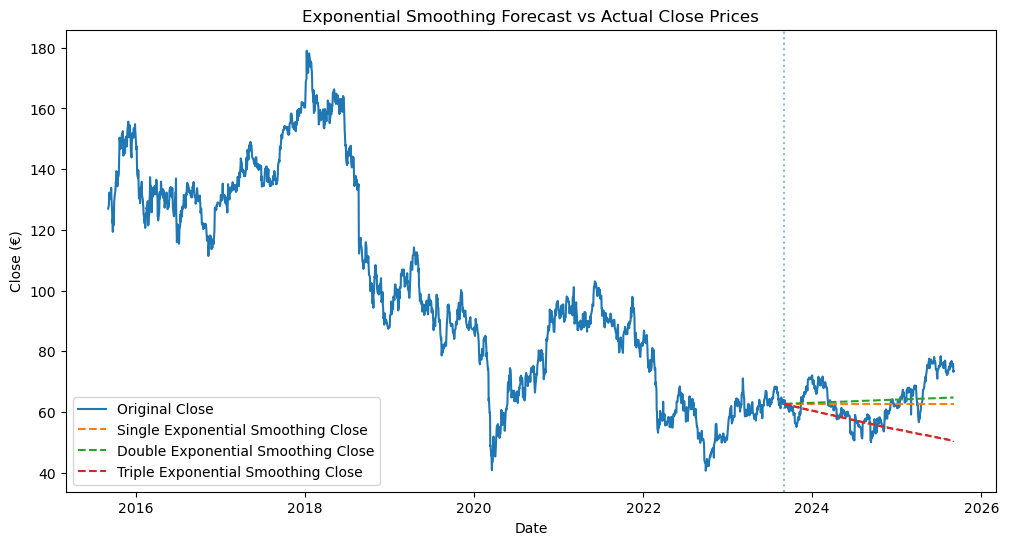

In [13]:
forecast_single = model_single_fit.forecast(steps=len(test))
forecast_series_single = pd.Series(forecast_single.values, index=test['Date'])

forecast_double = model_double_fit.forecast(steps=len(test))
forecast_series_double = pd.Series(forecast_double.values, index=test['Date'])

forecast_triple = model_triple_fit.forecast(steps=len(test))
forecast_series_triple = pd.Series(forecast_triple.values, index=test['Date'])

# Plot original Close vs Forecast
plt.figure(figsize=(12,6))
plt.plot(conti_stocks_df_new['Date'], conti_stocks_df_new['Close'], label="Original Close")
plt.plot(forecast_series_single.index, forecast_series_single, label="Single Exponential Smoothing Close", linestyle="--")
plt.plot(forecast_series_double.index, forecast_series_double, label="Double Exponential Smoothing Close", linestyle="--")
plt.plot(forecast_series_triple.index, forecast_series_triple, label="Triple Exponential Smoothing Close", linestyle="--")

# Mark training end
plt.axvline(conti_stocks_df_new["Date"].iloc[train_size-1], alpha=0.5, linestyle=":")

plt.xlabel("Date")
plt.ylabel("Close (€)")
plt.title("Exponential Smoothing Forecast vs Actual Close Prices")
plt.legend()
plt.show()

In [9]:
# Forecast for training (in-sample predictions)
train_pred_single = model_single_fit.predict(start=0, end=len(train)-1)

# Forecast for test set
test_forecast_single = model_single_fit.forecast(steps=len(test))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def calculate_metrics(actual, predicted, dataset_name=""):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    smape = 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    print(f"\nPerformance Metrics for {dataset_name}:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"sMAPE : {smape:.2f}%")


# Training metrics
calculate_metrics(train['Close'], train_pred_single, "Training")

# Testing metrics
calculate_metrics(test['Close'], test_forecast_single, "Testing")


Performance Metrics for Training:
MAE  : 1.4052
MSE  : 3.7868
RMSE : 1.9460
MAPE : 1.53%
sMAPE : 1.52%

Performance Metrics for Testing:
MAE  : 5.8531
MSE  : 50.7273
RMSE : 7.1223
MAPE : 9.04%
sMAPE : 9.14%


In [10]:
# Forecast for training (in-sample predictions)
train_pred_double = model_double_fit.predict(start=0, end=len(train)-1)

# Forecast for test set
test_forecast_double = model_double_fit.forecast(steps=len(test))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def calculate_metrics(actual, predicted, dataset_name=""):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    smape = 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    print(f"\nPerformance Metrics for {dataset_name}:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"sMAPE : {smape:.2f}%")


# Training metrics
calculate_metrics(train['Close'], train_pred_double, "Training")

# Testing metrics
calculate_metrics(test['Close'], test_forecast_double, "Testing")


Performance Metrics for Training:
MAE  : 1.4162
MSE  : 3.8348
RMSE : 1.9583
MAPE : 1.54%
sMAPE : 1.54%

Performance Metrics for Testing:
MAE  : 5.7256
MSE  : 46.1273
RMSE : 6.7917
MAPE : 9.01%
sMAPE : 8.94%


In [11]:
# Forecast for training (in-sample predictions)
train_pred_triple = model_triple_fit.predict(start=0, end=len(train)-1)

# Forecast for test set
test_forecast_triple = model_triple_fit.forecast(steps=len(test))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def calculate_metrics(actual, predicted, dataset_name=""):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    smape = 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    print(f"\nPerformance Metrics for {dataset_name}:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"sMAPE : {smape:.2f}%")


# Training metrics
calculate_metrics(train['Close'], train_pred_triple, "Training")

# Testing metrics
calculate_metrics(test['Close'], test_forecast_triple, "Testing")


Performance Metrics for Training:
MAE  : 1.4060
MSE  : 3.7733
RMSE : 1.9425
MAPE : 1.53%
sMAPE : 1.52%

Performance Metrics for Testing:
MAE  : 10.0727
MSE  : 185.6426
RMSE : 13.6251
MAPE : 14.64%
sMAPE : 16.71%
